In [1]:
from db.helpers import new_sales_collection
from db.queries import new_sales_refenrece_ids_with_sales_count
import pandas as pd
import random

In [88]:
def find_seg(data: list[dict], seg_len: int = 3):
    seg = []
    for i in data:
        if i["Monthly_Sales"] == None and len(seg) > 0:
            seg.append(i)
        if i["Monthly_Sales"] != None and len(seg) == 0:
            seg.append(i)

        if i["Monthly_Sales"] != None and len(seg) > 0:
            if len(seg) == 1:
                seg.append(i)
            else:
                if len(seg) > seg_len:
                    seg = []
                    seg.append(i)
                    continue
                seg.append(i)
                yield seg
                seg = []

In [89]:
all_sales = list(
    new_sales_collection.aggregate(
        pipeline=[
            {"$match": {"Monthly_Sales": {"$ne": None}}},
            {
                "$group": {
                    "_id": "$Brand",
                    "generated": {
                        "$push": {
                            "$cond": [
                                {"$eq": ["$Source", "Generated"]},
                                "$Monthly_Sales",
                                None,
                            ]
                        }
                    },
                    "actual": {
                        "$push": {
                            "$cond": [
                                {"$ne": ["$Source", "Generated"]},
                                "$Monthly_Sales",
                                None,
                            ]
                        }
                    },
                }
            },
            {"$unwind": {"path": "$generated"}},
            {"$unwind": {"path": "$actual"}},
            {
                "$group": {
                    "_id": "$_id",
                    "max_actual": {"$max": "$actual"},
                    "min_actual": {"$min": "$actual"},
                    "max_generated": {"$max": "$generated"},
                    "min_generated": {"$min": "$generated"},
                }
            },
            {"$match": {"max_actual": {"$ne": None}, "max_generated": {"$ne": None}}},
        ]
    )
)
df = pd.DataFrame(all_sales)

In [90]:
display(df)
display(df[df["max_generated"] > df["max_actual"]])

,_id,max_actual,min_actual,max_generated,min_generated
0,Trolley,186276.0,1716.00,278561.899335,620.000000
1,Giolitti,7840.0,6480.00,42465.555556,26580.000000
2,Payless ShoeSource,46580.0,3320.00,60760.000000,704.807626
3,PANCO,13060.0,13060.00,28479.880000,3499.000000
4,arabiata,21083.0,19362.00,16559.020408,4460.000000
...,...,...,...,...,...
2530,Le Notre Restaurant,86000.0,33480.00,79257.500000,16455.757576
2531,House of Joy,11620.0,3571.06,30297.760000,582.698760
2532,Health Planet Co.,27020.0,6524.00,40268.000000,1083.708247
2533,Chillo Cafe,29026.0,26390.00,33583.222222,2919.814518


,_id,max_actual,min_actual,max_generated,min_generated
0,Trolley,186276.0,1716.00,278561.899335,620.000000
1,Giolitti,7840.0,6480.00,42465.555556,26580.000000
2,Payless ShoeSource,46580.0,3320.00,60760.000000,704.807626
3,PANCO,13060.0,13060.00,28479.880000,3499.000000
5,Golden Oxygen Fashion,2752.0,2234.00,103230.061285,701.743248
...,...,...,...,...,...
2529,COVA,6280.0,5148.00,23180.583333,1497.673748
2531,House of Joy,11620.0,3571.06,30297.760000,582.698760
2532,Health Planet Co.,27020.0,6524.00,40268.000000,1083.708247
2533,Chillo Cafe,29026.0,26390.00,33583.222222,2919.814518


{'_id': 'Foodservice 6828', 'fieldN': 69}

'The Gathering Bistro'

'Generated'

65291.016

'Actual'

68534.0

<Axes: xlabel='Sales_Period'>

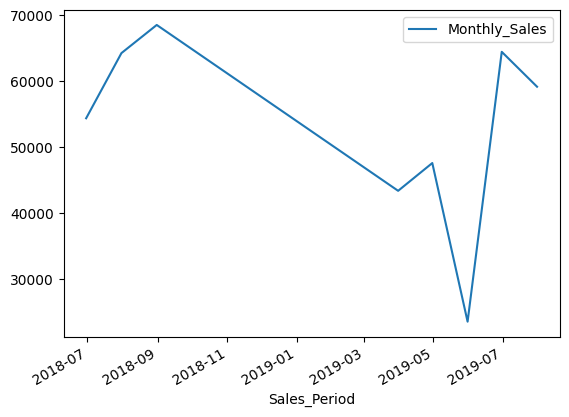

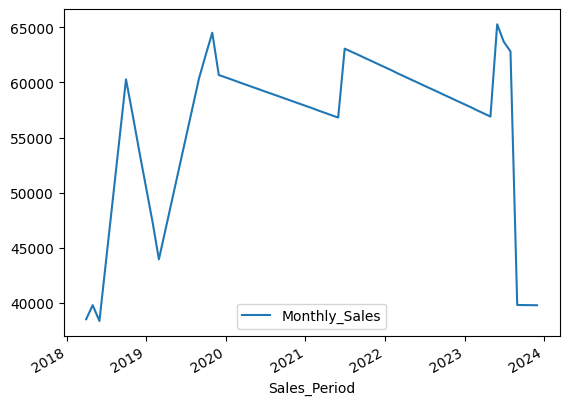

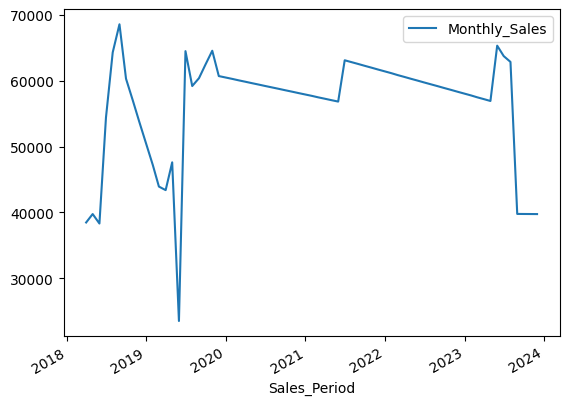

In [2]:
reference_ids = list(new_sales_refenrece_ids_with_sales_count())
id = random.choice(reference_ids)
# id = {'_id': 'Retail 170023', 'fieldN': 36}
sales = new_sales_collection.find({"Reference_Full_ID": id["_id"]})
sales = list(sales)
display(id, sales[0]["Brand"])
sales = pd.DataFrame(sales)
generated_filter = (
    (sales["Study"] == "Generated")
    & (sales["Researcher"] == "Mahmoud")
    & (sales["Source"] == "Generated")
    & (sales["Monthly_Sales"].notna())
)
actual_filter = (
    (sales["Study"] != "generated")
    & (sales["Source"] != "Generated")
    & (sales["Monthly_Sales"].notna())
)
display("Generated", sales[generated_filter]["Monthly_Sales"].max())
display("Actual", sales[actual_filter]["Monthly_Sales"].max())
sales[sales["Source"] != "Generated"].plot(x="Sales_Period", y="Monthly_Sales")
sales[sales["Source"] == "Generated"].plot(x="Sales_Period", y="Monthly_Sales")
sales.plot(x="Sales_Period", y="Monthly_Sales")
# sales['Monthly_Sales'] = sales['Monthly_Sales'].interpolate(limit_area='inside')
# display(sales['Monthly_Sales'])
# sales.plot(x='Sales_Period',y='Monthly_Sales')

In [3]:
id = {"_id": "Retail 170023", "fieldN": 36}
display(id)
sales = new_sales_collection.find(
    {"Reference_Full_ID": id["_id"], "Monthly_Sales": None}
)
df = pd.DataFrame(sales)
display(df.tail())

{'_id': 'Retail 170023', 'fieldN': 36}

""


In [4]:
import pandas as pd

df = pd.DataFrame(new_sales_collection.find({}))

,Monthly_Sales
count,41.000000
mean,7329.906889
std,5672.558381
min,1168.087742
25%,3907.167629
50%,4239.926954
75%,9720.976593
max,22726.750968


,Monthly_Sales
count,27.000000
mean,46871.511817
std,28399.792518
min,0.000000
25%,24439.000000
50%,54557.933333
75%,64452.500000
max,92265.000000


<Axes: title={'center': 'Retail 5214'}, xlabel='Sales_Period'>

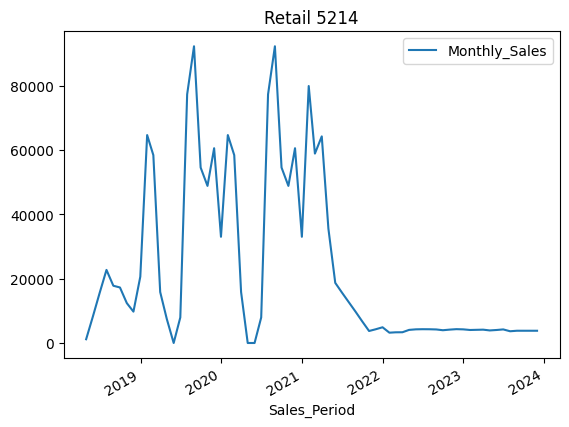

In [12]:
import pandas as pd

unique_rids = df["Reference_Full_ID"].unique()
id = random.choice(unique_rids)
id = "Retail 5214"

tmp = df[df["Reference_Full_ID"] == id].copy()
generated_df = tmp[tmp["Researcher"] == "Mahmoud"]
actual_df = tmp[tmp["Researcher"] != "Mahmoud"]
display(generated_df[["Monthly_Sales"]].describe())
display(actual_df[["Monthly_Sales"]].describe())
tmp.plot(title=id, x="Sales_Period", y="Monthly_Sales")

In [8]:
from prophet.plot import plot_plotly
import pandas as pd
from prophet import Prophet


def prophet_forecast_model(df: pd.DataFrame, key):
    tmp = df[[key, "Sales_Period"]].copy()
    tmp = tmp.set_index("Sales_Period")
    tmp = tmp.reset_index()[["Sales_Period", key]].rename(
        columns={"Sales_Period": "ds", key: "y"}
    )
    model = Prophet(
        # seasonality_mode="multiplicative",
        # weekly_seasonality=True,
        # yearly_seasonality=25,
        # seasonality_prior_scale=30,
    )
    return model.fit(tmp)


def get_prediction(model: Prophet, number_of_months):
    future_dates = model.make_future_dataframe(periods=number_of_months, freq="MS")
    predictions = model.predict(future_dates)
    return predictions


model = prophet_forecast_model(tmp, "Monthly_Sales")
forecast = get_prediction(model, 1)
plot_plotly(model, forecast)

12:06:20 - cmdstanpy - INFO - Chain [1] start processing
12:06:21 - cmdstanpy - INFO - Chain [1] done processing
/home/rageq8/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

